In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import scipy.stats as stats
import numpyro

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/shie/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-08-10 15:36:08,309 - hbmep.config - INFO - Verifying configuration ...
2023-08-10 15:36:08,309 - hbmep.config - INFO - Success!
2023-08-10 15:36:08,332 - hbmep.model.baseline - INFO - Initialized model with baseline link


2023-08-10 15:36:08,348 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-10 15:36:08,349 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/L_SHIE/fcr
2023-08-10 15:36:08,351 - hbmep.dataset.core - INFO - Processing data ...
2023-08-10 15:36:08,358 - hbmep.utils.utils - INFO - func:load took: 0.01 sec


In [10]:
subjects = df.participant.unique().tolist()
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x charge
conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x charge
conditions_inv = [f"{encoder_dict[model.features[0]].inverse_transform(np.array([pos]))[0]}::{encoder_dict[model.features[1]].inverse_transform(np.array([charge]))[0]}" for pos, charge in conditions]

# Subjects at condition
sub_at_cond = {}

for pos, charge in conditions:
    sub_at_cond[(pos, charge)] = []
    for sub in subjects:
        if (sub, pos, charge) in combinations:
            sub_at_cond[(pos, charge)].append(sub)

In [11]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]

a = None

for muscle in muscles:
    src = f"/home/vishu/repos/hbmep-paper/reports/L_SHIE/{muscle}"
    mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

    a_temp = mcmc[site.a].to_numpy()
    a_temp = a_temp.reshape(-1, *a_temp.shape[2:])

    if a is None:
        a = a_temp
    else:
        a = np.concatenate((a, a_temp), axis=-1)

a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0, independent=True))
# a_map = a.mean(axis=0)

In [5]:
a.shape

(24000, 2, 4, 8, 6)

In [17]:
i = 0
i_pos, i_charge = conditions[i]

j = 1
j_pos, j_charge = conditions[j]


i_sub = set(sub_at_cond[(i_pos, i_charge)])
j_sub = set(sub_at_cond[(j_pos, j_charge)])
common_sub = i_sub.intersection(j_sub)
common_sub = list(common_sub)

In [18]:
i_a = a[:, i_charge, i_pos, ...]
i_a.shape

(24000, 8, 6)

In [19]:
i_a = i_a[:, common_sub, ...]
i_a.shape

(24000, 8, 6)

In [21]:
i_a = i_a.reshape(i_a.shape[0], -1)
i_a.shape

(24000, 48)

In [ ]:
mu_a_estimate = a.mean(axis=1)
sigma_a_estimate = np.power(np.power(a - a.mean(axis=1)[:, None, :], 2).sum(axis=1) / 9, 0.5)

In [ ]:
np.power(np.power(i_a - a.mean(axis=1)[:, None, :], 2).sum(axis=1) / 9, 0.5)

In [39]:


np.power(np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1), 0.5)

array([144.99199141, 144.81389613, 117.88680786, ..., 143.23861738,
       146.52155228, 144.99642526])

In [45]:
def _effect_size(i_pos, i_charge, j_pos, j_charge, common_sub):
    N = len(subjects) * len(muscles)

    i_a = a[:, i_charge, i_pos, ...]
    i_a = i_a[:, common_sub, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)

    i_mu_a_estimate = i_a.mean(axis=-1)
    i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

    j_a = a[:, j_charge, j_pos, ...]
    j_a = j_a[:, common_sub, ...]
    j_a = j_a.reshape(j_a.shape[0], -1)

    j_mu_a_estimate = j_a.mean(axis=-1)
    j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

    i_j_effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)
    return i_j_effect_size

In [49]:
    N = len(subjects) * len(muscles)

    i_a = a[:, i_charge, i_pos, ...]
    i_a = i_a[:, common_sub, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)

    i_mu_a_estimate = i_a.mean(axis=-1)
    i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

    j_a = a[:, j_charge, j_pos, ...]
    j_a = j_a[:, common_sub, ...]
    j_a = j_a.reshape(j_a.shape[0], -1)

    j_mu_a_estimate = j_a.mean(axis=-1)
    j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

    i_j_effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)

    

In [53]:
from numpyro.diagnostics import hpdi

hpdi(i_j_effect_size, prob=.95)

array([0.02531738, 0.17286211])

In [55]:
((i_mu_a_estimate - j_mu_a_estimate) < 0).mean()

0.027416666666666666

<Axes: ylabel='Density'>

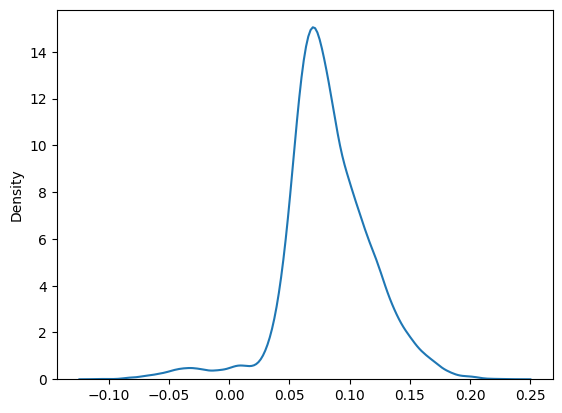

In [51]:
import seaborn as sns

sns.kdeplot(i_j_effect_size)

In [57]:
a, b = hpdi(i_j_effect_size, prob=.95)

In [59]:
b

0.17286211324170309

In [ ]:
def _process(keep_muscles: list[str]):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]
    keep_muscles_ind = list(set(keep_muscles_ind))

    pr = []
    effect_size = []
    t_test = []
    rank_test = []

    for i, (i_pos, i_charge) in enumerate(conditions):
        curr_pr = []
        curr_effect_size = []
        curr_t_test = []
        curr_rank_test = []

        for j, (j_pos, j_charge) in enumerate(conditions):
            if i == j:
                curr_pr.append(0)
                curr_t_test.append(1)
                curr_rank_test.append(1)
                continue

            i_sub = set(sub_at_cond[(i_pos, i_charge)])
            j_sub = set(sub_at_cond[(j_pos, j_charge)])
            common_sub = i_sub.intersection(j_sub)
            common_sub = list(common_sub)

            N = len(common_sub) * len(keep_muscles_ind)

            ## Distributions
            i_a = a[:, i_charge, i_pos, ...]
            i_a = i_a[:, common_sub, ...]
            i_a = i_a[..., keep_muscles_ind]
            i_a = i_a.reshape(i_a.shape[0], -1)

            j_a = a[:, j_charge, j_pos, ...]
            j_a = j_a[:, common_sub, ...]
            j_a = j_a[..., keep_muscles_ind]
            j_a = j_a.reshape(j_a.shape[0], -1)

            diff_a = i_a - j_a
            diff_a_mu = diff_a.mean(axis=-1)
            pr_a_mu = (diff_a_mu < 0).mean()
            curr_pr.append(pr_a_mu)

            ## Effect-size
            i_mu_a_estimate = i_a.mean(axis=-1)
            i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            j_a = a[:, j_charge, j_pos, ...]
            j_a = j_a[:, common_sub, ...]
            j_a = j_a.reshape(j_a.shape[0], -1)

            j_mu_a_estimate = j_a.mean(axis=-1)
            j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)
            hpdi_interval_lo, hpdi_interval_hi = hpdi(i_j_effect_size, prob=.95)

            ## MAP
            i_map = a_map[i_charge, i_pos, ...]
            i_map = i_map[common_sub, ...]
            i_map = i_map[..., keep_muscles_ind]
            i_map = i_map.reshape(-1,)

            j_map = a_map[j_charge, j_pos, ...]
            j_map = j_map[common_sub, ...]
            j_map = j_map[..., keep_muscles_ind]
            j_map = j_map.reshape(-1,)

            diff_map = i_map - j_map
            t_test_map = stats.ttest_1samp(a=diff_map, popmean=0, alternative="less")
            rank_test_map = stats.wilcoxon(x=diff_map, alternative="less")

            curr_t_test.append(t_test_map.pvalue)
            curr_rank_test.append(rank_test_map.pvalue)

        pr.append(curr_pr)
        curr_effect_size.append((hpdi_interval_lo, hpdi_interval_hi))
        t_test.append(curr_t_test)
        rank_test.append(curr_rank_test)

    pr = np.array(pr)
    effect_size.append(curr_effect_size)
    t_test = np.array(t_test)
    rank_test = np.array(rank_test)
    return pr, t_test, rank_test, df


In [5]:
a.shape

(24000, 2, 4, 8, 6)

In [6]:
a_map.shape

(2, 4, 8, 6)

In [7]:
# Subjects at condition
sub_at_cond = {}

for pos, charge in conditions:
    sub_at_cond[(pos, charge)] = []
    for sub in subjects:
        if (sub, pos, charge) in combinations:
            sub_at_cond[(pos, charge)].append(sub)

In [8]:
def _process(keep_muscles: list[str]):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]
    keep_muscles_ind = list(set(keep_muscles_ind))

    pr = []
    t_test = []
    rank_test = []

    for i, (i_pos, i_charge) in enumerate(conditions):
        curr_pr = []
        curr_t_test = []
        curr_rank_test = []

        for j, (j_pos, j_charge) in enumerate(conditions):
            if i == j:
                curr_pr.append(0)
                curr_t_test.append(1)
                curr_rank_test.append(1)
                continue

            i_sub = set(sub_at_cond[(i_pos, i_charge)])
            j_sub = set(sub_at_cond[(j_pos, j_charge)])
            common_sub = i_sub.intersection(j_sub)
            common_sub = list(common_sub)

            df = len(common_sub) * len(keep_muscles_ind)

            ## Distributions
            i_a = a[:, i_charge, i_pos, ...]
            i_a = i_a[:, common_sub, ...]
            i_a = i_a[..., keep_muscles_ind]
            i_a = i_a.reshape(i_a.shape[0], -1)

            j_a = a[:, j_charge, j_pos, ...]
            j_a = j_a[:, common_sub, ...]
            j_a = j_a[..., keep_muscles_ind]
            j_a = j_a.reshape(j_a.shape[0], -1)

            diff_a = i_a - j_a
            diff_a_mu = diff_a.mean(axis=-1)
            pr_a_mu = (diff_a_mu < 0).mean()
            curr_pr.append(pr_a_mu)

            ## MAP
            i_map = a_map[i_charge, i_pos, ...]
            i_map = i_map[common_sub, ...]
            i_map = i_map[..., keep_muscles_ind]
            i_map = i_map.reshape(-1,)

            j_map = a_map[j_charge, j_pos, ...]
            j_map = j_map[common_sub, ...]
            j_map = j_map[..., keep_muscles_ind]
            j_map = j_map.reshape(-1,)

            diff_map = i_map - j_map
            t_test_map = stats.ttest_1samp(a=diff_map, popmean=0, alternative="less")
            rank_test_map = stats.wilcoxon(x=diff_map, alternative="less")

            curr_t_test.append(t_test_map.pvalue)
            curr_rank_test.append(rank_test_map.pvalue)

        pr.append(curr_pr)
        t_test.append(curr_t_test)
        rank_test.append(curr_rank_test)

    pr = np.array(pr)
    t_test = np.array(t_test)
    rank_test = np.array(rank_test)
    return pr, t_test, rank_test, df


2023-08-10 11:59:07,581 - matplotlib.mathtext - INFO - Substituting symbol P from STIXNonUnicode
2023-08-10 11:59:07,582 - matplotlib.mathtext - INFO - Substituting symbol r from STIXGeneral
2023-08-10 11:59:08,340 - matplotlib.mathtext - INFO - Substituting symbol P from STIXNonUnicode
2023-08-10 11:59:08,341 - matplotlib.mathtext - INFO - Substituting symbol r from STIXGeneral


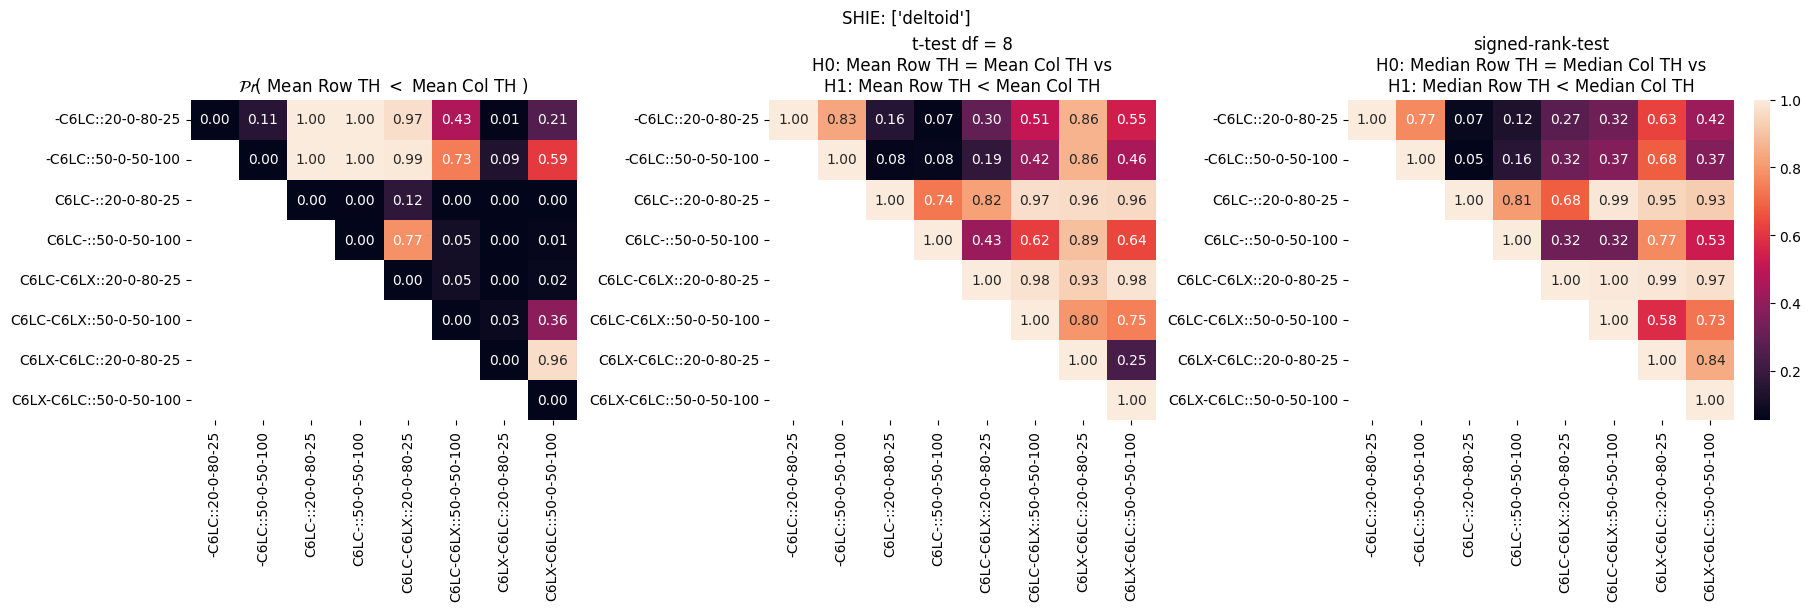

In [10]:
# ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
keep_muscles = ["deltoid"]
pr, t_test, rank_test, df = _process(keep_muscles=keep_muscles)

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), constrained_layout=True)

for j in range(ncols):
    ax = axes[j]

    if j == 0: sns.heatmap(pr, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", mask=np.tril(np.ones_like(pr), k=-1), ax=ax, cbar=False)
    if j == 0: ax.set_title("$\mathcal{Pr}($ Mean Row TH $<$ Mean Col TH $)$")

    if j == 1: sns.heatmap(t_test, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", mask=np.tril(np.ones_like(t_test), k=-1), ax=ax, cbar=False)
    if j == 1: ax.set_title(f"t-test df = {df}\nH0: Mean Row TH = Mean Col TH vs\nH1: Mean Row TH < Mean Col TH")

    if j == 2: sns.heatmap(rank_test, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", mask=np.tril(np.ones_like(rank_test), k=-1), ax=ax)
    if j == 2: ax.set_title("signed-rank-test\nH0: Median Row TH = Median Col TH vs\nH1: Median Row TH < Median Col TH")

fig.suptitle(f"SHIE: {keep_muscles}");

2023-08-10 12:10:13,978 - matplotlib.mathtext - INFO - Substituting symbol P from STIXNonUnicode
2023-08-10 12:10:13,979 - matplotlib.mathtext - INFO - Substituting symbol r from STIXGeneral
2023-08-10 12:10:14,400 - matplotlib.mathtext - INFO - Substituting symbol P from STIXNonUnicode
2023-08-10 12:10:14,401 - matplotlib.mathtext - INFO - Substituting symbol r from STIXGeneral


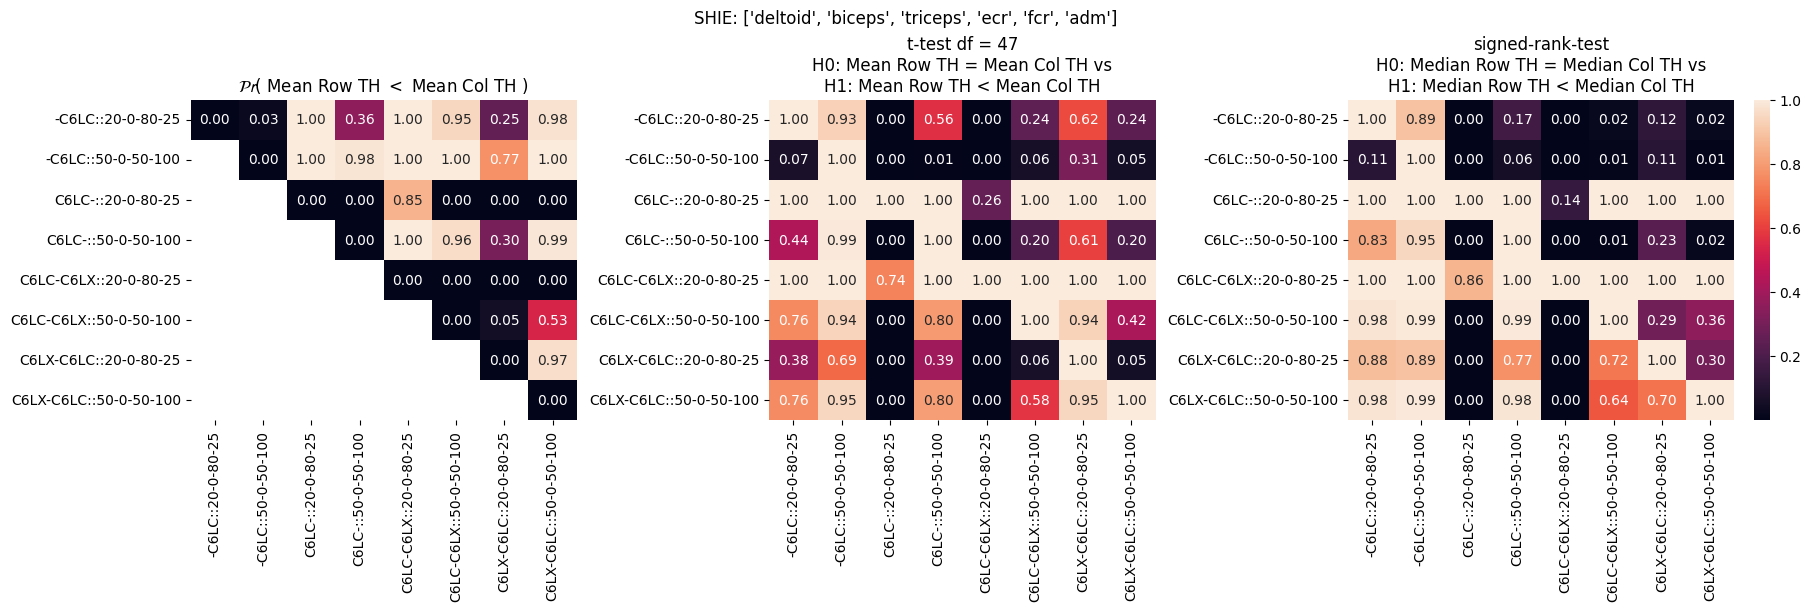

In [19]:
keep_muscles = muscles
pr, t_test, rank_test, df = _process(keep_muscles=keep_muscles)

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), constrained_layout=True)

for j in range(ncols):
    ax = axes[j]

    if j == 0: sns.heatmap(pr, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", mask=np.tril(np.ones_like(pr), k=-1), ax=ax, cbar=False)
    if j == 0: ax.set_title("$\mathcal{Pr}($ Mean Row TH $<$ Mean Col TH $)$")

    if j == 1: sns.heatmap(t_test, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", ax=ax, cbar=False)
    if j == 1: ax.set_title(f"t-test df = {df-1}\nH0: Mean Row TH = Mean Col TH vs\nH1: Mean Row TH < Mean Col TH")

    if j == 2: sns.heatmap(rank_test, xticklabels=conditions_inv, yticklabels=conditions_inv, annot=True, fmt=".2f", ax=ax)
    if j == 2: ax.set_title("signed-rank-test\nH0: Median Row TH = Median Col TH vs\nH1: Median Row TH < Median Col TH")

fig.suptitle(f"SHIE: {keep_muscles}");

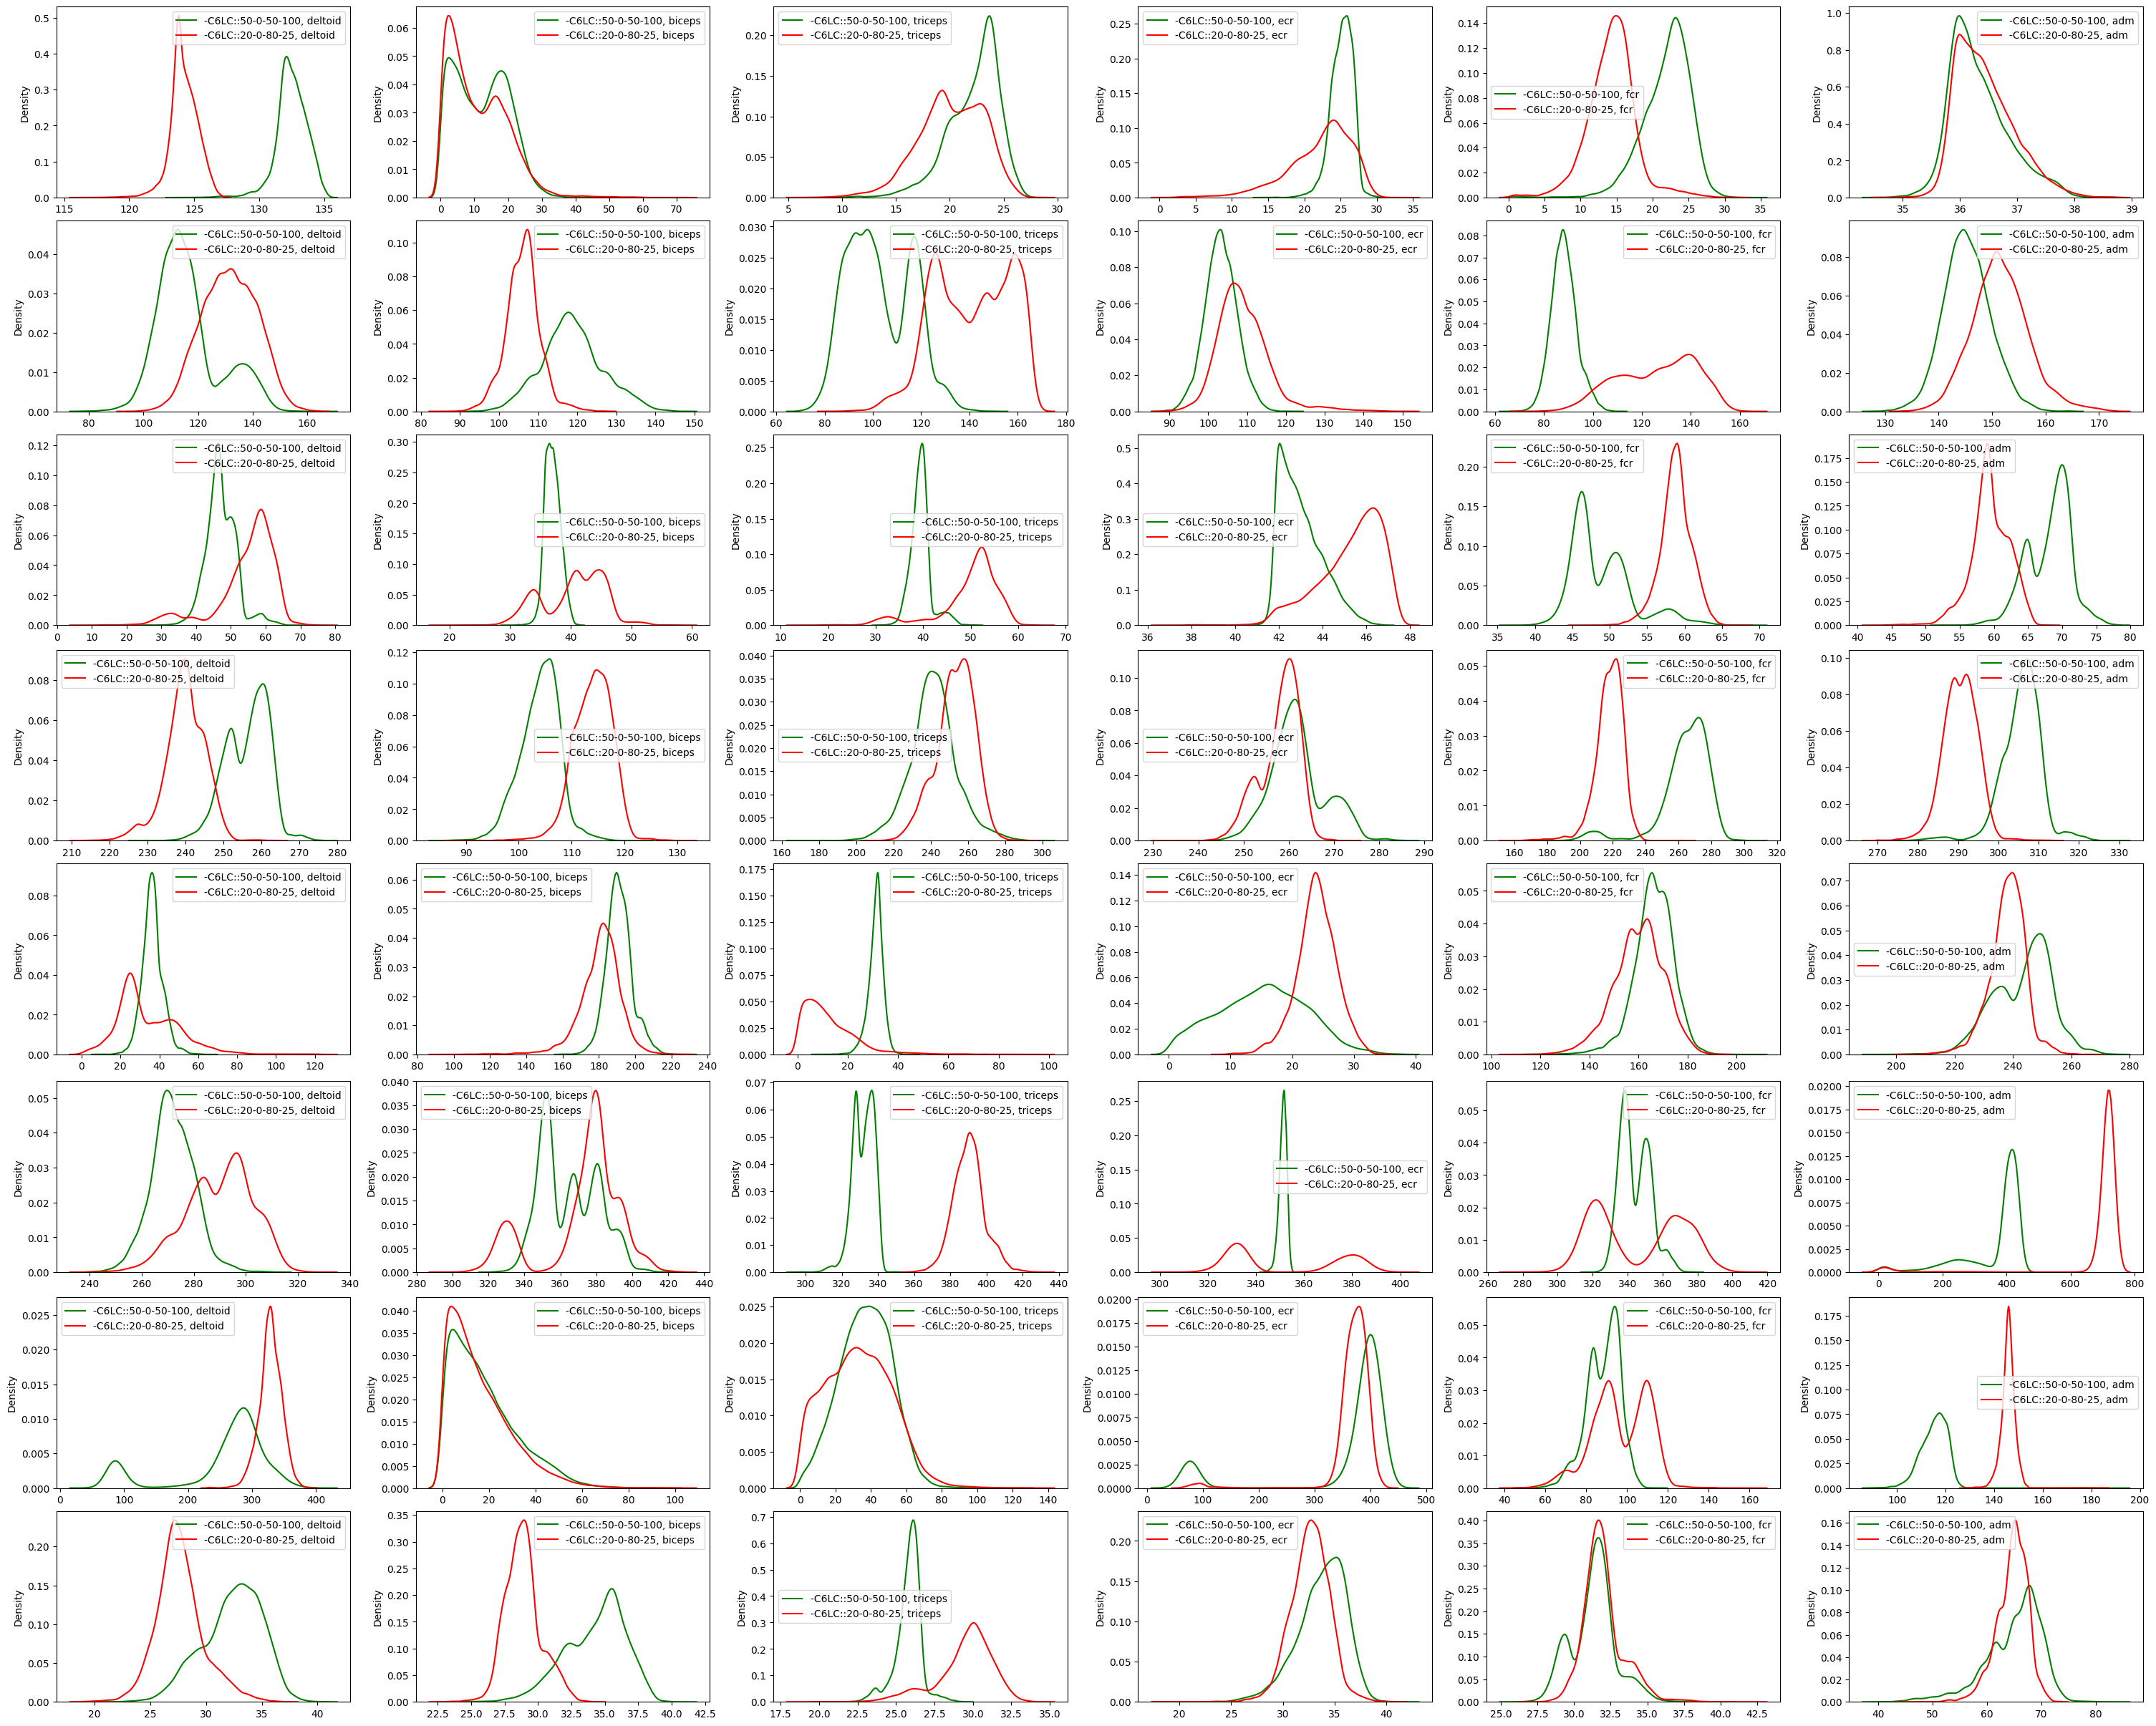

In [12]:
i_pos_inv = "-C6LC"
i_charge_inv = "50-0-50-100"

j_pos_inv = "-C6LC"
j_charge_inv = "20-0-80-25"

i_pos = encoder_dict[model.features[0]].transform(np.array([i_pos_inv]))[0]
i_charge = encoder_dict[model.features[1]].transform(np.array([i_charge_inv]))[0]

j_pos = encoder_dict[model.features[0]].transform(np.array([j_pos_inv]))[0]
j_charge = encoder_dict[model.features[1]].transform(np.array([j_charge_inv]))[0]

nrows = len(subjects)
ncols = len(muscles)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for sub in subjects:
    for m, muscle in enumerate(muscles):
        ax = axes[sub, m]
        sns.kdeplot(a[:, i_charge, i_pos, sub, m], label=f"{i_pos_inv}::{i_charge_inv}, {muscle}", ax=ax, color="green")
        sns.kdeplot(a[:, j_charge, j_pos, sub, m], label=f"{j_pos_inv}::{j_charge_inv}, {muscle}", ax=ax, color="red")
        ax.legend()

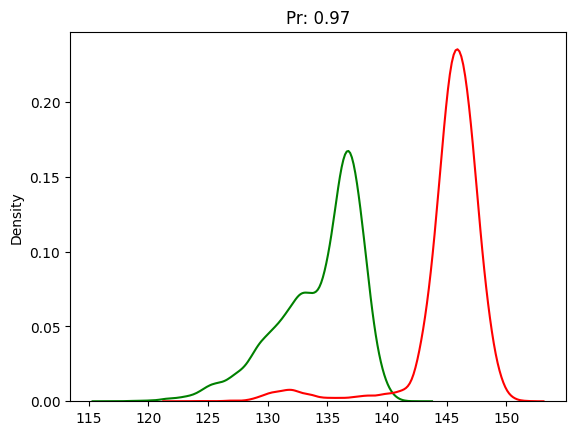

In [16]:
i_a = a[:, i_charge, i_pos, ...].reshape(24000, -1).mean(axis=-1)
j_a = a[:, j_charge, j_pos, ...].reshape(24000, -1).mean(axis=-1)

sns.kdeplot(i_a, label=f"{i_pos_inv}::{i_charge_inv}", color="green")
sns.kdeplot(j_a, label=f"{j_pos_inv}::{j_charge_inv}", color="red")
plt.title(f"Pr: {(i_a < j_a).mean():.2f}");
